# Style Transfer with CycleGAN

Megan Arnold
September 18, 2025

# Introduction

The purpose of this notebook is to explore Generative Adversarial Networks in the context of CycleGANs. The requirements of this project are to take photos and convert them to Monet style paintings. In the dataset, there are about 7000 photos, and only about 300 Monet paintings. Because of this discrepancy in count and pairing, CycleGAN networks are required for this style transfer to be successful. 

CycleGANs are a type of GAN network that can learn image to image transfer without requiring paired examples (like pix2pix)<sup>[1]</sup>. CycleGANs have two generatative networks and two discriminative networks. There are three losses that are calculated for the generative nettworks during training. The first generative network is tasked with learning how to transfer the Monet style paintings to the photos. The second generative network is tasked with converting the Monet style paintings into photos. The first loss is the **discriminator loss**, which is calculated by how well the discriminator can tell the difference between the real and fake Monet and the real and fake photos. The second loss is the **cycle Loss** which is calculated by how well the first generative network can convert the photo to a Monet style painting and then the second generative network can convert that Monet style painting back to the original photo. The cycle loss is the comparision of the original photo to the twice converted photo. The third loss is the **identity loss** which is calculated by how well the first generative network can convert a Monet style painting to a Monet style painting and how well the second generative network can convert a photo to a photo. The identity loss then compares the oringal Monet image to the once converted Monet image and the original photo to the once converted photo. 

The discriminator networks are used to classify the real and generated images of their respective generative networks. The discriminator networks are trained in conjunction with the generative networks. During this project, I will show you the challenges I had with the discriminator networks being too accurate too quickly and how I attempted to overcome those challenges and the recommendations I have for future work.

The dataset used to train this CycleGAN is from the Kaggle competition "I'm Somethign of a Painter Myself" <sup>[2]</sup>. This dataset contains about 7000 photos and 300 Monet style paintings. The size of the images (both Monet paintings and photos) are 256x256 pixels with 3 color channels. This dataset is unpaired, but the size consistency will help the design of the network architecture and preprocessing pipeline.

# Table of Contents

1. Imports and Setup
2. Data Input Pipelines
3. Exploratory Data Analysis
    1. Dataset Counts
    2. Monet Examples
    3. Photo Examples
    4. Pixel Distributions
4. Model Architecture and Strategy
    1. Discriminator Architecture
    2. Generator Architecture
    3. Optimizer and Compilation
5. Training Loop and Loss Functions
6. Baseline Results
7. Hyper Parameter Tuning
    1. Version 2 Discriminator Adjustments
        1. Simplified Architecture
        2. Learning Rate Adjustments
    2. Version 2 Generator Adjustments
        1. Upscale and Conv2D for Generator
        2. Learning Rate Adjustments
    3. Version 2 Results
    4. Version 3 Discriminator Adjustments
    5. Version 3 Generator Adjustments
    6. Version 3 Results
8. Results
9. Discussion and Future Work
10. References



# Imports and setup

In [ ]:
# https://www.tensorflow.org/install/source#gpu # TF to Cuda
# https://docs.nvidia.com/deeplearning/cudnn/backend/latest/reference/support-matrix.html # Cuda to CuDNN

import os
import sys
import gc

os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true" 

import tensorflow as tf
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        
tf.keras.backend.clear_session()
gc.collect()
import keras as k

print(k.__version__)

print(tf.config.list_physical_devices("GPU"))
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
print(tf.config.list_physical_devices("GPU"))

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))  
print("TensorFlow version:", tf.__version__)  
print("cuDNN version:", tf.sysconfig.get_build_info()['cudnn_version'])  



['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/megarnol/projects/MSDS_Notes_Playground/.venv/lib/python3.10/site-packages']
['/home/megarnol/projects/MSDS_Notes_Playground/.venv/lib/python3.10/site-packages', '/home/megarnol/projects/MSDS_Notes_Playground/.venv/local/lib/python3.10/dist-packages', '/home/megarnol/projects/MSDS_Notes_Playground/.venv/lib/python3/dist-packages', '/home/megarnol/projects/MSDS_Notes_Playground/.venv/lib/python3.10/dist-packages']
/home/megarnol/.local/lib/python3.10/site-packages


2025-09-06 16:25:31.069388: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-06 16:25:31.454957: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-06 16:25:31.455073: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-06 16:25:31.511658: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-06 16:25:31.642741: I tensorflow/core/platform/cpu_feature_guar

2.15.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.15.0
Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-09-06 16:25:34.717694: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-09-06 16:25:34.965459: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-09-06 16:25:34.965500: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
# Helper functions
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
# CONSTANTS
TRAIN_SIZE = 0.8

ROOT_DIR = os.getcwd()
DATA_DIR = f"{ROOT_DIR}/data"
MONET_DIR = f"{DATA_DIR}/monet"
PHOTO_DIR = f"{DATA_DIR}/photos"
MODEL_DIR = f"{ROOT_DIR}/models"
IMAGE_DIR = f"{ROOT_DIR}/images"
CHECKPOINT_DIR = f"{ROOT_DIR}/checkpoints"
BATCH_SIZE = 8
print(DATA_DIR)


/home/megarnol/projects/MSDS_Notes_Playground/DTSA 5511 Deep Learning/Week 5/data


# Data Input Pipelines

https://www.tensorflow.org/guide/data

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory
monet_images = tf.keras.utils.image_dataset_from_directory(
    MONET_DIR,
    labels=[1] * (len(os.listdir(MONET_DIR)) - 1),  # True means the image is monet
    batch_size=BATCH_SIZE,
)
monet_images = monet_images.shuffle(buffer_size=300)
H = monet_images.element_spec[0].shape[1]
W = monet_images.element_spec[0].shape[2]
C = monet_images.element_spec[0].shape[3]


def preprocess(image, label):
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0
    return image, label


monet_images = monet_images.map(preprocess)

photo_images = tf.keras.utils.image_dataset_from_directory(
    PHOTO_DIR,
    labels=[0] * (len(os.listdir(PHOTO_DIR)) - 1),  # False means the image is not monet
    batch_size=BATCH_SIZE,
)
photo_images = photo_images.shuffle(buffer_size=(len(os.listdir(PHOTO_DIR)) - 1))
photo_images = photo_images.map(preprocess)

Found 300 files belonging to 1 classes.


2025-09-13 20:10:15.154156: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-09-13 20:10:15.340473: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-09-13 20:10:15.340528: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-09-13 20:10:15.343224: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-09-13 20:10:15.343275: I external/local_xla/xla/stream_executor

Found 7038 files belonging to 1 classes.


# EDA

During EDA, I will look at a sample of the Monet style paintings and photos to get a feel for the data. I will also look at the distribution of the image pixel values to see if there are any outliers. I will also look at the balance of the dataset.

The distribution of the dataset counts is about 7000 photos and 300 Monet style paintings. This is a significant imbalance, but that's what CycleGAN would expect and compensate for. This just reiterates the need for using CycleGAN vs Pix2Pix <sup>[1]</sup> for this project.

Both the Photos and Monet style paintings are all 256x256 pixels with 3 color channels. The Money paintings appear to be clean and like paintings. There are some photos that have watermarks; however, I think these watermarks are small enough to not impact the training significantly. If the photo generator network begins to add watermarks to the generated photos, then I will need to address this issue.

In the histograms, the distributions of all channels and both datasets are fairly flat. The photos do have a cluster of pixels with 0 values, but I don't think this is significant. If there seems to be an issue during the generative process, this discrepancy may be something that I have to address, but for now, I won't do any transformations to the data aside from normalizing the pixel values to be between -1 and 1.

## Dataset Counts


In [25]:
# Counts
monet_length = len(os.listdir(MONET_DIR)) - 1 # .gitkeep file
photo_length = len(os.listdir(PHOTO_DIR)) - 1
print(f"Number of Monet style paintings: {monet_length}")
print(f"Number of photos: {photo_length}")

Number of Monet style paintings: 300
Number of photos: 7038


## Monet Samples

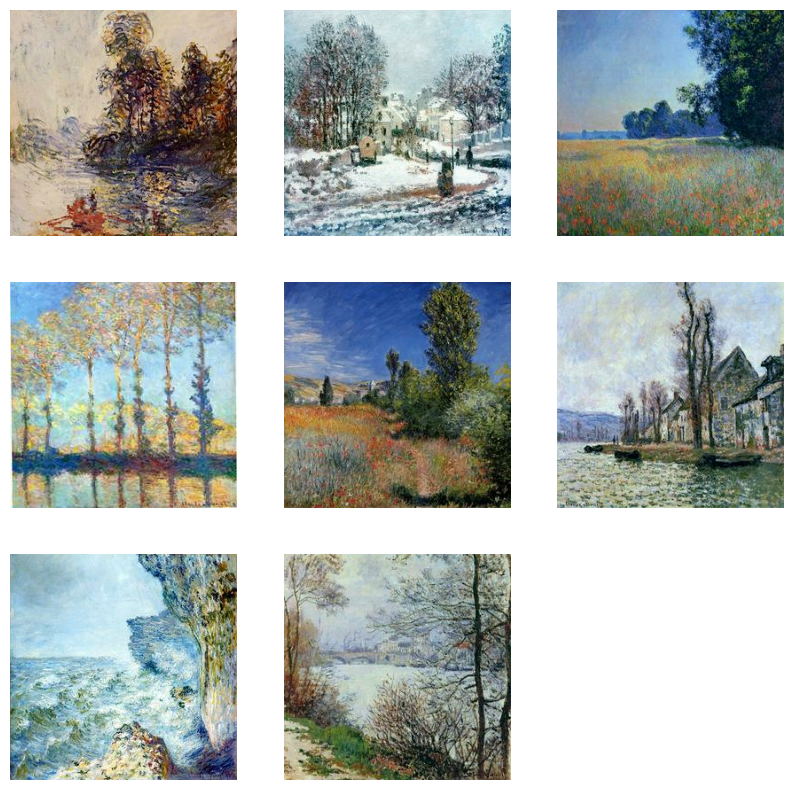

In [ ]:
# plot some monets
plt.figure(figsize=(10, 10))
for images, labels in monet_images.take(1): # Takes 1 batch, not 1 image
    for i in range(min(9,BATCH_SIZE)):
        ax = plt.subplot(3, 3, i + 1)
        image = images[i]
        image = (image + 1.0) * 127.5
        image = tf.clip_by_value(image, 0, 255)
        plt.imshow(image.numpy().astype("uint8"))
        plt.axis("off")

## Photo Samples

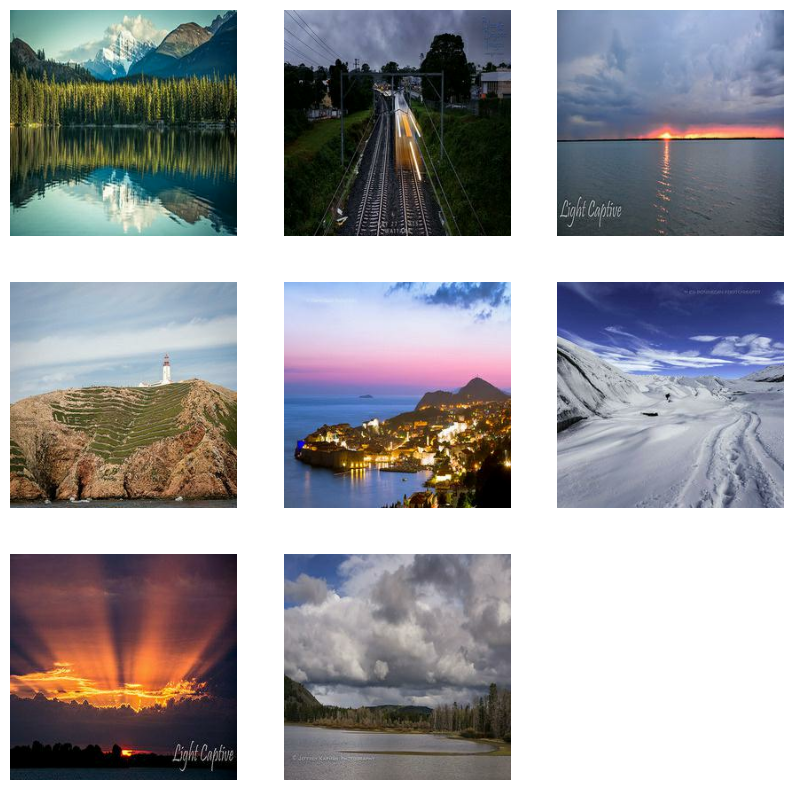

In [8]:
# plot some photes
plt.figure(figsize=(10, 10))
for images, labels in photo_images.take(1): # Takes 1 batch, not 1 image
    for i in range(min(9,BATCH_SIZE)):
        ax = plt.subplot(3, 3, i + 1)
        image = images[i]
        # Reverse the preprocessing only for displaying. #TODO: worth making a reverse function? Nah
        image = (image + 1.0) * 127.5
        image = tf.clip_by_value(image, 0, 255)
        plt.imshow(image.numpy().astype("uint8"))
        plt.axis("off")

## Pixel Distribution

In the pixel distribution, we can see that there is a very flat distribution in both the Monet style paintings and the photos, and they take up the entire range of pixel values from 0 to 255. There are more instances of lower pixel values in the photos, but I don't think that will impact the training. I would expect the Generative networks to be able to accommodate the differences.

In [ ]:
# RGB histograms of Monet dataset
bin_count = int(np.ceil(256/8))
red_count_m = np.zeros(bin_count)
green_count_m = np.zeros(bin_count)
blue_count_m = np.zeros(bin_count)
red_count_p = np.zeros(bin_count)
green_count_p = np.zeros(bin_count)
blue_count_p = np.zeros(bin_count)
for images, _ in monet_images:
    reverted_monet_images = (images + 1.0) * 127.5 # Convert back to [0, 255]
    red_values = tf.cast(reverted_monet_images[:,:,:,0], tf.int32).numpy().flatten()
    green_values = tf.cast(reverted_monet_images[:,:,:,1], tf.int32).numpy().flatten()
    blue_values = tf.cast(reverted_monet_images[:,:,:,2], tf.int32).numpy().flatten()

    red_count_m += np.histogram(red_values, bins=bin_count, range=(0, 256))[0]
    green_count_m += np.histogram(green_values, bins=bin_count, range=(0, 256))[0]
    blue_count_m += np.histogram(blue_values, bins=bin_count, range=(0, 256))[0]

for images, _ in photo_images:
    reverted_photos = (images + 1.0) * 127.5 # Convert back to [0, 255]
    red_values = tf.cast(reverted_photos[:,:,:,0], tf.int32).numpy().flatten()
    green_values = tf.cast(reverted_photos[:,:,:,1], tf.int32).numpy().flatten()
    blue_values = tf.cast(reverted_photos[:,:,:,2], tf.int32).numpy().flatten()

    red_count_p += np.histogram(red_values, bins=bin_count, range=(0, 256))[0]
    green_count_p += np.histogram(green_values, bins=bin_count, range=(0, 256))[0]
    blue_count_p += np.histogram(blue_values, bins=bin_count, range=(0, 256))[0]



32


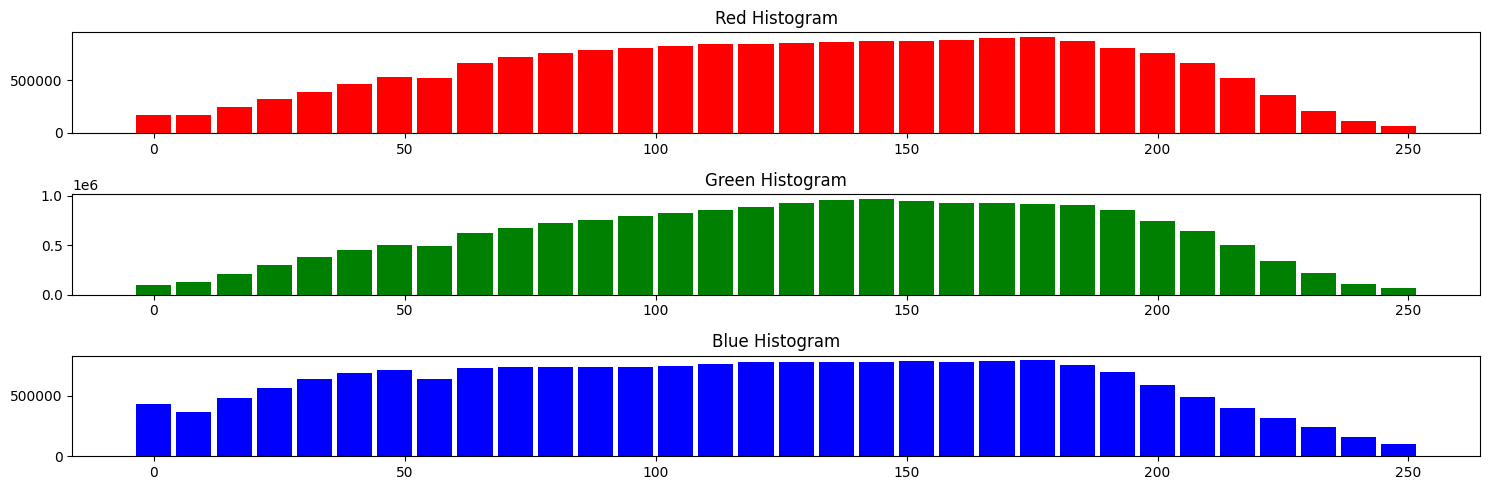

In [20]:
# Monet Histograms
plt.figure(figsize=(15, 5))
plt.subplot(3, 1, 1)
plt.bar(np.arange(bin_count)*8, red_count_m, color='red', width=7)
plt.title('Red Histogram')
plt.subplot(3, 1, 2)
plt.bar(np.arange(bin_count)*8, green_count_m, color='green', width=7)
plt.title('Green Histogram')
plt.subplot(3, 1, 3)
plt.bar(np.arange(bin_count)*8, blue_count_m, color='blue', width=7)
plt.title('Blue Histogram')
plt.tight_layout()
plt.show()

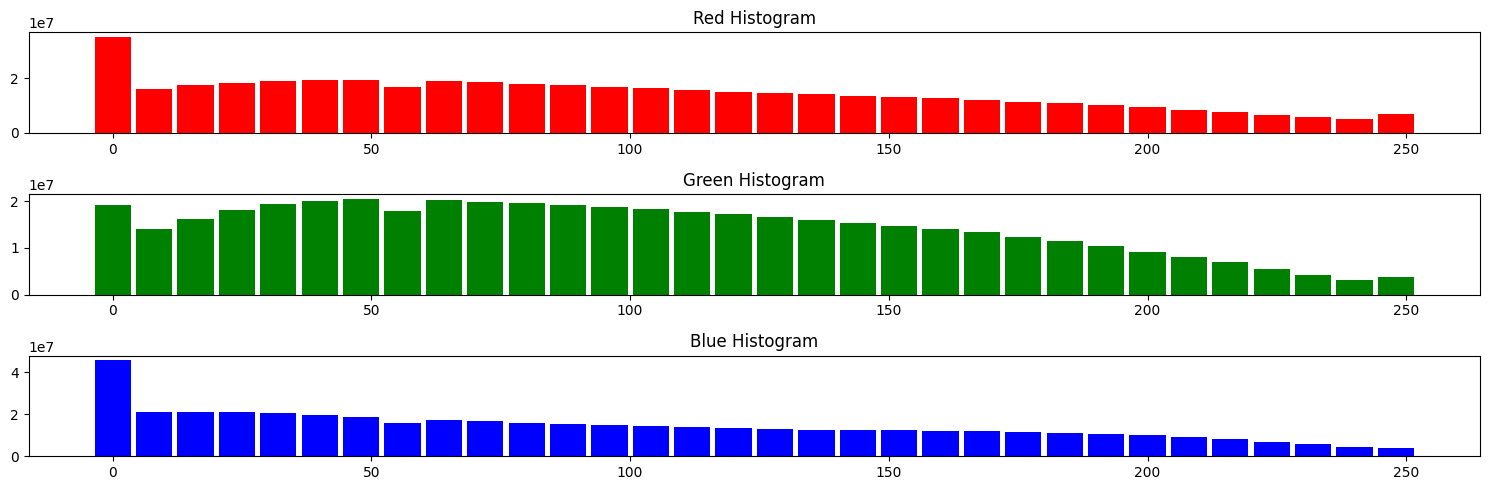

In [ ]:
# Photo Histograms
plt.figure(figsize=(15, 5))
plt.subplot(3, 1, 1)
plt.bar(np.arange(bin_count)*8, red_count_p, color='red', width=7)
plt.title('Red Histogram')
plt.subplot(3, 1, 2)
plt.bar(np.arange(bin_count)*8, green_count_p, color='green', width=7)
plt.title('Green Histogram')
plt.subplot(3, 1, 3)
plt.bar(np.arange(bin_count)*8, blue_count_p, color='blue', width=7)
plt.title('Blue Histogram')
plt.tight_layout()
plt.show()

# Model Strategy

CycleGAN<sup>[3]</sup> is the architecture necessary to do style conversion. It works by having two generators and two discriminators. The first generator converts the photos to a monet style, the second generator converts the monet style back to photes. These two generators are necessary to ensure the first generator doesn't lose the structure of the photos. The fake monet image is passed through the second generator to convert it back to a photo. The loss between the original photo and the reconstructed photo is used as a portion of the loss to train the first generator. The two discriminators are used to ensure that the generated images are similar to the original photo with the added style of money. The first discriminator is used to classify real monet images from fake monet images (The main discriminator for this project). The second generator is used to detect real photos from fake photos. This second discriminator is used as part of the loss for the second generator. The reason these two additional generator and discriminator are necessary is only to ensure the original photo structure remains after the style transfer. This type of architecture isn't necessarily needed for the Kaggle project; however, with only 300 monet images, there aren't enough to train the classic GAN architecture. The CycleGAN architecture allows the model to learn the style transfer with unpaired images, which is necessary given the limited number of monet images.

The four networks that make up the CycleGAN architecture are:

1. Generative Network 1: Photo to Monet
2. Generative Network 2: Monet to Photo
3. Discriminator Network 1: Real Monet vs Fake Monet
4. Discriminator Network 2: Real Photo vs Fake Photo

Below is a diagram of the CycleGAN architecture. In this project, Domain A are Photos and Domain B are Monet style paintings, as the purpose is to convert photos to Monet style paintings; however, this architecture is reversible, meaning that the model can also convert Monet style paintings back to photos.

![CycleGAN Architecture](./CycleGAN%20Architecture.png)


<sup>[4]</sup> "CycleGAN: unpaired Image-to-Image Translation (Part 1) - PyImageSearch"


# Discriminators

The discriminators are going to be fairly simple convolutional neural networks for binary classification. The input will be a 256x256x3 image, and the output will be the sigmoid activation of a single neuron between 0 and 1. These networks will train at the same time as the generator networks. Ideally, they will improve together, but if the discriminator betcomes too good too quickly, then the generator will receive a consistent loss from that portion of the loss function. It will still be able to improve from the cycle loss and identity loss; however, it won't be ideal as it won't get better at generating realistic images. 

Later in this project, I will discuss the challenges that I had with the discriminator networks outperforming the generator networks and how I attempted to correct this. However, I wasn't able to fully correct the issue, so I will discuss some future work that may be able to improve this inbalance in performance.

In [ ]:
# Discriminator

from keras.layers import (
    Input,
    LeakyReLU,
    GlobalAveragePooling2D,
    Dense,
    MaxPooling2D,
    Conv2D,
    Dropout,
)
from keras.models import Sequential
from keras.optimizers import Adam


def build_discriminator(input_shape):
    model = Sequential(
        [
            Input(shape=input_shape),
            Conv2D(32, kernel_size=3, padding="same"),
            LeakyReLU(alpha=0.1),
            MaxPooling2D(),
            Dropout(0.25),
            Conv2D(64, kernel_size=3, padding="same"),
            LeakyReLU(alpha=0.1),
            MaxPooling2D(),
            Dropout(0.25),
            Conv2D(128, kernel_size=3, padding="same"),
            LeakyReLU(alpha=0.1),
            MaxPooling2D(),
            Dropout(0.25),
            Conv2D(256, kernel_size=3, padding="same"),
            LeakyReLU(alpha=0.1),
            MaxPooling2D(),
            Dropout(0.25),
            GlobalAveragePooling2D(),
            Dense(64),
            LeakyReLU(alpha=0.1),
            Dense(1, activation="sigmoid"),
        ]
    )
    return model



## ENCODER / DECODER definition

In [ ]:
# Generator encoder-decoder architecture
from keras.layers import (
    Conv2DTranspose,
    Conv2D,
    LeakyReLU,
    Input,
    Dense,
    GlobalAveragePooling2D,
    MaxPooling2D,
    BatchNormalization,
)
from keras.models import Sequential


def build_autoencoder(input_shape):
    encoder_layers = [
        Input(shape=input_shape),
        Conv2D(32, kernel_size=3, padding="same"),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(),
        Conv2D(64, kernel_size=3, padding="same"),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(),
        Conv2D(128, kernel_size=3, padding="same"),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(),
        Conv2D(256, kernel_size=3, padding="same"),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(),
        Conv2D(512, kernel_size=3, padding="same"),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
    ]

    decoder_layers = [
        Conv2DTranspose(256, kernel_size=3, padding="same", strides=2), # stride to compensate for maxpool
        LeakyReLU(alpha=0.1),
        Conv2DTranspose(128, kernel_size=3, padding="same", strides=2),
        LeakyReLU(alpha=0.1),
        Conv2DTranspose(64, kernel_size=3, padding="same", strides=2),
        LeakyReLU(alpha=0.1),
        Conv2DTranspose(32, kernel_size=3, padding="same", strides=2),
        LeakyReLU(alpha=0.1),
        Conv2DTranspose(3, kernel_size=3, padding="same", activation="tanh"),
    ]

    autoencoder = Sequential(encoder_layers + decoder_layers)
    return autoencoder, Sequential(encoder_layers), Sequential(decoder_layers)

## Optimizer and Compilation

I chose to use the Adam optimizer with a learning rate of 0.0001 and beta of 0.5 for both the generators and discriminator networks. These can be adjusted in the hyperparameter tuning section if necessary. Adam optimizers are computationally efficient and adapts the learning rates for each parameter based on the moments of the gradients <sup>[5]</sup>. Both the generators and discriminators will use the same optimizer configuration.

In [ ]:
# Same architecture for discriminatorse
discriminator_monet_identifier = build_discriminator(
    (H, W, C)
)  # Input is monet generator output
discriminator_photo_identifier = build_discriminator(
    (H, W, C)
)  #  Input is photo generator output

discriminator_monet_opt = Adam(learning_rate=0.0001, beta_1=0.5)
discriminator_photo_opt = Adam(learning_rate=0.0001, beta_1=0.5)
discriminator_monet_identifier.compile(
    loss="binary_crossentropy", optimizer=discriminator_monet_opt, metrics=["accuracy"]
)
discriminator_photo_identifier.compile(
    loss="binary_crossentropy", optimizer=discriminator_photo_opt, metrics=["accuracy"]
)

generator_monet, _, _ = build_autoencoder((H, W, C))
generator_photo, _, _ = build_autoencoder((H, W, C))

generator_monet_opt = Adam(learning_rate=0.0001, beta_1=0.5)
generator_photo_opt = Adam(learning_rate=0.0001, beta_1=0.5)
generator_monet.compile(
    loss="mse", optimizer=generator_monet_opt
)  # MSE loss for autoencoder. [3]
generator_photo.compile(loss="mse", optimizer=generator_photo_opt)
#generator_monet.summary()
generator_photo.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 batch_normalization_5 (Bat  (None, 256, 256, 32)      128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 128, 128, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 batch_normalization_6 (Bat  (None, 128, 128, 64)     

# Training Loop

The train_step function is where the custom training loop is defined. This function uses tensorflow's GradientTape to calculate the gradients for the generator and discriminator networks. I go through the different generation and discrimination steps. This includes the cycle loss, identity loss, and the discriminator loss steps. Those losses are calculated, either through binary cross entropy for the classification losses or mean absolute error for the cycle and identity losses. The total loss for each network is calculated, and then the gradients are applied to the respective networks for the future epochs. 

This is the baseline training loop with some notable features:
- Each loss has the same weight of 1.0 for applying the gradients to the generators. In the future, I needed to adjust this due to some imbalances in the output that I will discuss later.
- The generator and discriminator have the same learning rate of 0.0001. In the future, I adjust this for the discriminator because it was learning too quickly and not providing valuable information to the generator networks. 

Overall, this is a very straight forward implementation of CycleGAN training loop <sup>[6]</sup>. I will use this as my baseline and make adjustments to the architecture and parameters in future iterations.

In [ ]:
# Checkpoints to help mitigate data loss if something crashes
checkpoint = tf.train.Checkpoint(
    generator_monet=generator_monet,
    generator_photo=generator_photo,
    discriminator_monet_identifier=discriminator_monet_identifier,
    discriminator_photo_identifier=discriminator_photo_identifier,
    generator_monet_opt=generator_monet_opt,
    generator_photo_opt=generator_photo_opt,
    discriminator_monet_opt=discriminator_monet_opt,
    discriminator_photo_opt=discriminator_photo_opt,
)
checkpoint_manager = tf.train.CheckpointManager(
    checkpoint, CHECKPOINT_DIR, max_to_keep=10
)


In [13]:
discriminator_loss_fn = tf.keras.losses.BinaryCrossentropy()
cycle_loss_fn = tf.keras.losses.MeanAbsoluteError()
identity_loss_fn = tf.keras.losses.MeanAbsoluteError()


@tf.function
def train_step(monet_images, photo_images):

    with tf.GradientTape(persistent=True) as tape:
        # Generate images
        generated_monet_images = generator_monet(photo_images, training=True)
        generated_photo_images = generator_photo(monet_images, training=True)

        # Cycle images to ensure structure
        cycled_photo_images = generator_photo(
            generated_monet_images, training=True
        )  # Should be compared to photo_images
        cycled_monet_images = generator_monet(
            generated_photo_images, training=True
        )  # Should be compared to monet_images

        # Identity loss images
        same_monet_images = generator_monet(
            monet_images, training=True
        )  # Are also used for structure. Monet to Monet shouldn't undergo significant style chjange
        same_photo_images = generator_photo(photo_images, training=True)

        # Discriminator outputs
        disc_real_monet = discriminator_monet_identifier(monet_images, training=True)
        disc_fake_monet = discriminator_monet_identifier(
            generated_monet_images, training=True
        )

        disc_real_photo = discriminator_photo_identifier(photo_images, training=True)
        disc_fake_photo = discriminator_photo_identifier(
            generated_photo_images, training=True
        )

        # Discriminator Loss
        discriminator_monet_real_loss = discriminator_loss_fn(
            tf.ones_like(disc_real_monet), disc_real_monet
        )
        discriminator_monet_fake_loss = discriminator_loss_fn(
            tf.zeros_like(disc_fake_monet), disc_fake_monet
        )
        discriminator_monet_loss = (
            discriminator_monet_real_loss + discriminator_monet_fake_loss
        )

        discriminator_photo_real_loss = discriminator_loss_fn(
            tf.ones_like(disc_real_photo), disc_real_photo
        )
        discriminator_photo_fake_loss = discriminator_loss_fn(
            tf.zeros_like(disc_fake_photo), disc_fake_photo
        )
        discriminator_photo_loss = (
            discriminator_photo_real_loss + discriminator_photo_fake_loss
        )

        # Cycle Loss
        cycle_monet_loss = cycle_loss_fn(
            monet_images, cycled_monet_images
        )  # Verified correct comparison...
        cycle_photo_loss = cycle_loss_fn(photo_images, cycled_photo_images)
        total_cycle_loss = cycle_monet_loss + cycle_photo_loss

        # Identity Loss
        identity_monet_loss = identity_loss_fn(monet_images, same_monet_images)
        identity_photo_loss = identity_loss_fn(photo_images, same_photo_images)

        # Total Gen Loss
        total_generator_monet_loss = (
            discriminator_monet_loss + total_cycle_loss + identity_monet_loss
        )
        total_generator_photo_loss = (
            discriminator_photo_loss + total_cycle_loss + identity_photo_loss
        )

    # Calculate the gradients
    generator_monet_gradients = tape.gradient(
        total_generator_monet_loss, generator_monet.trainable_variables
    )
    generator_photo_gradients = tape.gradient(
        total_generator_photo_loss, generator_photo.trainable_variables
    )

    discriminator_monet_gradients = tape.gradient(
        discriminator_monet_loss, discriminator_monet_identifier.trainable_variables
    )
    discriminator_photo_gradients = tape.gradient(
        discriminator_photo_loss, discriminator_photo_identifier.trainable_variables
    )

    # Apply the gradients
    generator_monet_opt.apply_gradients(
        zip(generator_monet_gradients, generator_monet.trainable_variables)
    )
    generator_photo_opt.apply_gradients(
        zip(generator_photo_gradients, generator_photo.trainable_variables)
    )
    discriminator_monet_opt.apply_gradients(
        zip(
            discriminator_monet_gradients,
            discriminator_monet_identifier.trainable_variables,
        )
    )
    discriminator_photo_opt.apply_gradients(
        zip(
            discriminator_photo_gradients,
            discriminator_photo_identifier.trainable_variables,
        )
    )

    return (
        total_generator_monet_loss,
        total_generator_photo_loss,
        discriminator_monet_loss,
        discriminator_photo_loss,
    )

In [14]:
def get_intermediate_generated_images(g_monet, g_photo, train_ds):
    monet_images_sample = None
    photo_images_sample = None
    for monet_batch, photo_batch in train_ds.take(1):
        monet_images_sample = monet_batch[0]
        photo_images_sample = photo_batch[0]
    generated_monet_images_sample = g_monet(photo_images_sample, training=False)
    generated_photo_images_sample = g_photo(monet_images_sample, training=False)
    return (
        monet_images_sample,
        photo_images_sample,
        generated_monet_images_sample,
        generated_photo_images_sample,
    )


def plot_intermediate_generated_images(
    epoch,
    monet_images_sample,
    photo_images_sample,
    generated_monet_images_sample,
    generated_photo_images_sample,
):

    _, ax = plt.subplots(2, 2, figsize=(10, 10))
    ax[0, 0].set_title("Monet images")
    ax[0, 0].imshow(((monet_images_sample[0] + 1.0) * 127.5).numpy().astype("uint8"))
    ax[0, 1].set_title("Generated photo images from Monet")
    ax[0, 1].imshow(
        ((generated_photo_images_sample[0] + 1.0) * 127.5).numpy().astype("uint8")
    )
    ax[1, 0].set_title("Photo images")
    ax[1, 0].imshow(((photo_images_sample[0] + 1.0) * 127.5).numpy().astype("uint8"))
    ax[1, 1].set_title("Generated Monet images from Photo")
    ax[1, 1].imshow(
        ((generated_monet_images_sample[0] + 1.0) * 127.5).numpy().astype("uint8")
    )
    plt.tight_layout()
    plt.savefig(f"{IMAGE_DIR}/epoch_{epoch}_generated_images_test.png")
    plt.close()
    
def plot_training_history(history):
    plt.figure(figsize=(12, 8))
    plt.plot(history['gen_monet_loss'], label='Generator Monet Loss')
    plt.plot(history['gen_photo_loss'], label='Generator Photo Loss')
    plt.plot(history['disc_monet_loss'], label='Discriminator Monet Loss')
    plt.plot(history['disc_photo_loss'], label='Discriminator Photo Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{IMAGE_DIR}/training_history.png")
    plt.close()

In [ ]:
from tqdm import tqdm
import pickle

monet_ds = monet_images.repeat()
photo_ds = photo_images
total_batches = sum(1 for _ in photo_ds)
train_ds = tf.data.Dataset.zip((monet_ds, photo_ds))

history = {
    "gen_monet_loss": [],
    "gen_photo_loss": [],
    "disc_monet_loss": [],
    "disc_photo_loss": [],
}

EPOCHS = 200  # test
for epoch in range(EPOCHS):
    gmls, gpls, dmls, dpls = [], [], [], []
    print("Epoch:", epoch)
    n = 0
    for step, (monet_batch, photo_batch) in enumerate(
        tqdm(train_ds, total=total_batches)
    ):
        monet_x, _ = monet_batch
        photo_x, _ = photo_batch
        if monet_x.shape[0] != photo_x.shape[0]:
            print(
                "Skipping batch due to size mismatch. Total photes not divisible by batch size."
            )
            continue
        gml, gpl, dml, dpl = train_step(monet_x, photo_x)

        gmls.append(gml)
        gpls.append(gpl)
        dmls.append(dml)
        dpls.append(dpl)

    history["gen_monet_loss"].append(np.mean(gmls))
    history["gen_photo_loss"].append(np.mean(gpls))
    history["disc_monet_loss"].append(np.mean(dmls))
    history["disc_photo_loss"].append(np.mean(dpls))

    if epoch % 1 == 0:
        checkpoint_manager.save()
        (
            monet_images_sample,
            photo_images_sample,
            generated_monet_images_sample,
            generated_photo_images_sample,
        ) = get_intermediate_generated_images(
            generator_monet, generator_photo, train_ds
        )
        plot_intermediate_generated_images(
            epoch,
            monet_images_sample,
            photo_images_sample,
            generated_monet_images_sample,
            generated_photo_images_sample,
        )
    # save training history
    with open(f"{CHECKPOINT_DIR}/training_history.pkl", "wb") as f:
        pickle.dump(history, f)
    plot_training_history(history)


In [17]:
# Save all models
generator_monet.save(f"{MODEL_DIR}/generator_monet.h5")
generator_photo.save(f"{MODEL_DIR}/generator_photo.h5")
discriminator_monet_identifier.save(f"{MODEL_DIR}/discriminator_monet.h5")
discriminator_photo_identifier.save(f"{MODEL_DIR}/discriminator_photo.h5")

/home/megarnol/projects/MSDS_Notes_Playground/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Results of Baseline Model

After ensure the model was working as intended, I trained the model for 200 epochs. Below are examples of the generator output at the first epoch, the 25th epoch, and the final epoch. I also included the training curves for the generator and discriminator losses. I will discuss what I learned in the subsections below.

### Training Curves

The generator curve looks as I expect. It's slightly noisy; however, there is a trend downwards. Since this was taking longer than I expected to train, I also slightly increased the learning rate of the generator in the next iteration. The discriminator curve very quickly reached a vary low loss and remained there. I think this is due to the discriminator being too accurate too quickly. For future iterations, I chose to reduce the learning rate of the discriminator and significantly reduced the complexity of the architecture.

![Training Curves](./images_baseline_model/training_history.png)

### First Epoch
The first epoch was better than I expected. The most notable issues are the checkerboard patterns from the generator. This will presist throughout the 200 epoch training, so my next model iteration will focus on reducing this artifact.

![First Epoch](./images_baseline_model/epoch_0_generated_images_test.png)

### 25th Epoch
The 25th epoch shows more detail and color than the first epoch. The checkerboard artifacts are still present, but much less noticable.

![25th Epoch](./images_baseline_model/epoch_25_generated_images_test.png)

### Final Epoch
The final epoch of this baseline model was trained for 200 epochs. The images are still very blurry and lack detail. The checkerboard patterns are still very present. The colors are also different than expected as the output of the generator. It is able to retain the structure of the original input photo. This structure retention is due to the cycle loss and identity loss.


![Final Epoch](./images_baseline_model/epoch_199_generated_images_test.png)

Overall, I think this is a reasonable baseline model for CycleGAN. The next iterations, I will focus on reducing the checkerboard artifacts, improving the detail of the images, and attempting to make the discriminator and generator losses more balanced throughout the training.

# Version 2 HyperParameter Tuning Strategy

There were two main issues with the baseline model that I wanted to address in the next iteration. The first issue was the checkerboard artifacts that were present in the generated images. The second issue was the imbalance between the generator and discriminator losses. The discriminator was reaching a very low loss very quickly, which meant it wasn't providing valuable feedback to the generator.

To address the checkerboard artifacts, I learned that using Conv2DTranspose layers can cause this artifact<sup>[7]</sup>. The recommended attempt at a solution is to use Upsampling2D layers and then a Conv2D layer. I made that change for version 2 of the generator. I will discuss the results of the changes in the results section based on my observations from the different epochs of this training phase.

To address the imbalance between the generator and discriminator losses, I made two changes to the discriminator. The first change was to reduce the learning rate from 0.0001 to 0.00005. The second change was to reduce the complexity of the discriminator architecture. I reduced the number of convolutional blocks from 4 to 2. I will discuss the results of these changes in the results section, along with what my next steps would be to further improve the balance between the generator and discriminator losses.

- Reduced the learning rate of the discriminator from 0.0001 to 0.00005
- Reduced the number of convolutional blocks in the discriminator
- Upsampling2D + Conv2D instead of Conv2DTranspose for the generator<sup>[7]</sup>
- Increased the learning rate of the generator from 0.0001 to 0.0003

## Discriminator Redefinition

Since the discriminator was reaching perfect accuracy too quickly, I made the following changes. I will discuss the results of these changes in the results section.
- Reduced the learning rate
- Reduced the number of CNN blocks


In [18]:
# Discriminator
def build_discriminator_v2(input_shape):
    model = Sequential(
        [
            Input(shape=input_shape),
            Conv2D(32, kernel_size=3, padding="same"),
            LeakyReLU(alpha=0.1),
            MaxPooling2D(),
            Dropout(0.25),
            Conv2D(64, kernel_size=3, padding="same"),
            LeakyReLU(alpha=0.1),
            MaxPooling2D(),
            Dropout(0.25),
            Dropout(0.25),
            GlobalAveragePooling2D(),
            Dense(64),
            LeakyReLU(alpha=0.1),
            Dense(1, activation="sigmoid"),
        ]
    )
    return model

## Generator Definition

Since the generator was producing checkerboard artifacts and was a little slow compared to the discriminator, I made the following changes. I will discuss the results of these changes in the results section.
- Increase the learning rate
- Instead of Conv2dTranspose, use Upsampling2D + Conv2D [1]

In [ ]:
# Generator encoder-decoder architecture
from keras.layers import (
    UpSampling2D,
)

def build_autoencoder_v2(input_shape):
    encoder_layers = [
        Input(shape=input_shape),
        Conv2D(32, kernel_size=3, padding="same"),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(),
        Conv2D(64, kernel_size=3, padding="same"),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(),
        Conv2D(128, kernel_size=3, padding="same"),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(),
        Conv2D(256, kernel_size=3, padding="same"),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(),
        Conv2D(512, kernel_size=3, padding="same"),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
    ]

    decoder_layers = [
        UpSampling2D(),
        Conv2D(256, kernel_size=3, padding="same"),
        LeakyReLU(alpha=0.1),
        UpSampling2D(),
        Conv2D(128, kernel_size=3, padding="same"),
        LeakyReLU(alpha=0.1),
        UpSampling2D(),
        Conv2D(64, kernel_size=3, padding="same"),
        LeakyReLU(alpha=0.1),
        UpSampling2D(),
        Conv2D(32, kernel_size=3, padding="same"),
        LeakyReLU(alpha=0.1),
        Conv2D(3, kernel_size=3, padding="same", activation="tanh"),
    ]

    autoencoder = Sequential(encoder_layers + decoder_layers)
    return autoencoder, Sequential(encoder_layers), Sequential(decoder_layers)

In [29]:
# Same architecture for discriminatorse
discriminator_monet_identifier_v2 = build_discriminator_v2(
    (H, W, C)
)  # Input is monet generator output
discriminator_photo_identifier_v2 = build_discriminator_v2(
    (H, W, C)
)  #  Input is photo generator output

discriminator_monet_opt_v2 = Adam(learning_rate=0.00005, beta_1=0.5) # originally 0.0001
discriminator_photo_opt_v2 = Adam(learning_rate=0.00005, beta_1=0.5) # originally 0.0001
discriminator_monet_identifier_v2.compile(
    loss="binary_crossentropy", optimizer=discriminator_monet_opt_v2, metrics=["accuracy"]
)
discriminator_photo_identifier_v2.compile(
    loss="binary_crossentropy", optimizer=discriminator_photo_opt_v2, metrics=["accuracy"]
)

generator_monet_v2, _, _ = build_autoencoder_v2((H, W, C))
generator_photo_v2, _, _ = build_autoencoder_v2((H, W, C))

generator_monet_opt_v2 = Adam(learning_rate=0.0003, beta_1=0.5)
generator_photo_opt_v2 = Adam(learning_rate=0.0003, beta_1=0.5)
generator_monet_v2.compile(
    loss="mse", optimizer=generator_monet_opt_v2
)
generator_photo_v2.compile(loss="mse", optimizer=generator_photo_opt_v2)

generator_photo_v2.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_66 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 batch_normalization_30 (Ba  (None, 256, 256, 32)      128       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_76 (LeakyReLU)  (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 128, 128, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_67 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 batch_normalization_31 (Ba  (None, 128, 128, 64)    

In [22]:
# Checkpoints? How do I use this?
checkpoint = tf.train.Checkpoint(
    generator_monet=generator_monet,
    generator_photo=generator_photo,
    discriminator_monet_identifier=discriminator_monet_identifier,
    discriminator_photo_identifier=discriminator_photo_identifier,
    generator_monet_opt=generator_monet_opt,
    generator_photo_opt=generator_photo_opt,
    discriminator_monet_opt=discriminator_monet_opt,
    discriminator_photo_opt=discriminator_photo_opt,
    generator_monet_v2=generator_monet_v2,
    generator_photo_v2=generator_photo_v2,
    discriminator_monet_identifier_v2=discriminator_monet_identifier_v2,
    discriminator_photo_identifier_v2=discriminator_photo_identifier_v2,
    generator_monet_opt_v2=generator_monet_opt_v2,
    generator_photo_opt_v2=generator_photo_opt_v2,
    discriminator_monet_opt_v2=discriminator_monet_opt_v2,
    discriminator_photo_opt_v2=discriminator_photo_opt_v2,
)
checkpoint_manager = tf.train.CheckpointManager(
    checkpoint, CHECKPOINT_DIR, max_to_keep=10
)


In [30]:
discriminator_loss_fn = tf.keras.losses.BinaryCrossentropy()
cycle_loss_fn = tf.keras.losses.MeanAbsoluteError()
identity_loss_fn = tf.keras.losses.MeanAbsoluteError()


@tf.function
def train_step_v2(monet_images, photo_images):

    with tf.GradientTape(persistent=True) as tape:
        # Generate images
        generated_monet_images_v2 = generator_monet_v2(photo_images, training=True)
        generated_photo_images_v2 = generator_photo_v2(monet_images, training=True)

        # Cycle images to ensure structure
        cycled_photo_images_v2 = generator_photo_v2(
            generated_monet_images_v2, training=True
        )  # Should be compared to photo_images
        cycled_monet_images_v2 = generator_monet_v2(
            generated_photo_images_v2, training=True
        )  # Should be compared to monet_images

        # Identity loss images
        same_monet_images_v2 = generator_monet_v2(
            monet_images, training=True
        )  # Are also used for structure. Monet to Monet shouldn't undergo significant style change
        same_photo_images_v2 = generator_photo_v2(photo_images, training=True)

        # Discriminator outputs
        disc_real_monet_v2 = discriminator_monet_identifier_v2(monet_images, training=True)
        disc_fake_monet_v2 = discriminator_monet_identifier_v2(
            generated_monet_images_v2, training=True
        )

        disc_real_photo_v2 = discriminator_photo_identifier_v2(photo_images, training=True)
        disc_fake_photo_v2 = discriminator_photo_identifier_v2(
            generated_photo_images_v2, training=True
        )

        # Discriminator Loss
        discriminator_monet_real_loss = discriminator_loss_fn(
            tf.ones_like(disc_real_monet_v2), disc_real_monet_v2
        )
        discriminator_monet_fake_loss = discriminator_loss_fn(
            tf.zeros_like(disc_fake_monet_v2), disc_fake_monet_v2
        )
        discriminator_monet_loss = (
            discriminator_monet_real_loss + discriminator_monet_fake_loss
        )

        discriminator_photo_real_loss = discriminator_loss_fn(
            tf.ones_like(disc_real_photo_v2), disc_real_photo_v2
        )
        discriminator_photo_fake_loss = discriminator_loss_fn(
            tf.zeros_like(disc_fake_photo_v2), disc_fake_photo_v2
        )
        discriminator_photo_loss = (
            discriminator_photo_real_loss + discriminator_photo_fake_loss
        )

        # Cycle Loss
        cycle_monet_loss = cycle_loss_fn(
            monet_images, cycled_monet_images_v2
        )  # Verified correct comparison...
        cycle_photo_loss = cycle_loss_fn(photo_images, cycled_photo_images_v2)
        total_cycle_loss = cycle_monet_loss + cycle_photo_loss

        # Identity Loss
        identity_monet_loss = identity_loss_fn(monet_images, same_monet_images_v2)
        identity_photo_loss = identity_loss_fn(photo_images, same_photo_images_v2)

        # Total Gen Loss
        total_generator_monet_loss = (
            discriminator_monet_loss + total_cycle_loss + identity_monet_loss
        )
        total_generator_photo_loss = (
            discriminator_photo_loss + total_cycle_loss + identity_photo_loss
        )

    # Calculate the gradients
    generator_monet_gradients = tape.gradient(
        total_generator_monet_loss, generator_monet_v2.trainable_variables
    )
    generator_photo_gradients = tape.gradient(
        total_generator_photo_loss, generator_photo_v2.trainable_variables
    )

    discriminator_monet_gradients = tape.gradient(
        discriminator_monet_loss, discriminator_monet_identifier_v2.trainable_variables
    )
    discriminator_photo_gradients = tape.gradient(
        discriminator_photo_loss, discriminator_photo_identifier_v2.trainable_variables
    )

    # Apply the gradients
    generator_monet_opt_v2.apply_gradients(
        zip(generator_monet_gradients, generator_monet_v2.trainable_variables)
    )
    generator_photo_opt_v2.apply_gradients(
        zip(generator_photo_gradients, generator_photo_v2.trainable_variables)
    )
    discriminator_monet_opt_v2.apply_gradients(
        zip(
            discriminator_monet_gradients,
            discriminator_monet_identifier_v2.trainable_variables,
        )
    )
    discriminator_photo_opt_v2.apply_gradients(
        zip(
            discriminator_photo_gradients,
            discriminator_photo_identifier_v2.trainable_variables,
        )
    )

    return (
        total_generator_monet_loss,
        total_generator_photo_loss,
        discriminator_monet_loss,
        discriminator_photo_loss,
    )

In [ ]:
monet_ds = monet_images.repeat()
photo_ds = photo_images
total_batches = sum(1 for _ in photo_ds)
train_ds = tf.data.Dataset.zip((monet_ds, photo_ds))

history_v2 = {
    "gen_monet_loss": [],
    "gen_photo_loss": [],
    "disc_monet_loss": [],
    "disc_photo_loss": [],
}

EPOCHS = 200  # test
for epoch in range(EPOCHS):
    gmls, gpls, dmls, dpls = [], [], [], []
    print("Epoch:", epoch)
    n = 0
    for step, (monet_batch, photo_batch) in enumerate(
        tqdm(train_ds, total=total_batches)
    ):
        monet_x, _ = monet_batch
        photo_x, _ = photo_batch
        if monet_x.shape[0] != photo_x.shape[0]:
            # print(
            #     "Skipping batch due to size mismatch. Total photes not divisible by batch size."
            # )
            continue
        gml, gpl, dml, dpl = train_step_v2(monet_x, photo_x)

        gmls.append(gml)
        gpls.append(gpl)
        dmls.append(dml)
        dpls.append(dpl)

    history_v2["gen_monet_loss"].append(np.mean(gmls))
    history_v2["gen_photo_loss"].append(np.mean(gpls))
    history_v2["disc_monet_loss"].append(np.mean(dmls))
    history_v2["disc_photo_loss"].append(np.mean(dpls))

    if epoch % 1 == 0:
        checkpoint_manager.save()
        (
            monet_images_sample,
            photo_images_sample,
            generated_monet_images_sample,
            generated_photo_images_sample,
        ) = get_intermediate_generated_images(
            generator_monet_v2, generator_photo_v2, train_ds
        )
        plot_intermediate_generated_images(
            epoch,
            monet_images_sample,
            photo_images_sample,
            generated_monet_images_sample,
            generated_photo_images_sample,
        )
    # save training history
    with open(f"{CHECKPOINT_DIR}/training_history_v2.pkl", "wb") as f:
        pickle.dump(history_v2, f)
    plot_training_history(history_v2)

In [34]:
# Save all models
generator_monet_v2.save(f"{MODEL_DIR}/generator_monet_v2.h5")
generator_photo_v2.save(f"{MODEL_DIR}/generator_photo_v2.h5")
discriminator_monet_identifier_v2.save(f"{MODEL_DIR}/discriminator_monet_v2.h5")
discriminator_photo_identifier_v2.save(f"{MODEL_DIR}/discriminator_photo_v2.h5")

/home/megarnol/projects/MSDS_Notes_Playground/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Results of Upscaled Generator and Simplified Discriminator

I trained this model for 24 epochs, as there were significant issues with the images being generated and the training losses. First, the discriminator was still too powerful and quickly reached a very low loss. This meant that the generator was not receiving helpful gradients from the discriminator. However, the generator is still able to improve from the cycle loss and identity loss, but there were artifacts in the generated images that I will discuss. 

In all the examples below, the photo generator is a green tint to the image, then the Monet generator has a red tint to the image. I believe that this artifact was learned because the cycle losses learned that applying a red tint to the green tint of the photo generator would return the original photo. I expected the identity loss to prevent this, but it wasn't strong enough to mitagate this issue. I will address this in the future iteration by increasing the weight of the identity loss compared to the cycle loss. I will also address the discriminator being to powerful by decreasing the weight of the discriminator loss compared to the cycle and identity losses.

### Training Curves

The discriminator is still too powerful. Also, the generator loss is very noisy, but was trending downwards. If I didn't see the color artifacts in the gnerated images, I would have trained for more epochs to see if this leveled out, but I didn't want to waste the compute time.

![Training Curves](./images_V2/training_history.png)

### First Epoch

In these generated images, there are very obvious edge artifacts, along with the green and red tints that I discussed earlier. The checkerboard artifacts are no longer as obvious as the intial architecture. This is likely due to the change from Conv2DTranspose to Upsampling2D and Conv2D.

![First Epoch](./images_V2/epoch_0_generated_images_test.png)

### 10th Epoch

These images still have the color tints, but they are less noticable. The edge artifacts have been reduced, but the image is still very blurry.


![10th Epoch](./images_V2/epoch_10_generated_images_test.png)

### Final Epoch

The final epoch before I stopped the training showed that the color artifacts were getting worse, and there were boundary artifacts around the contrast changes in the image. This artifact is most noticable in the generated photos with the tree branches in the top left of the image.


![Final Epoch](./images_V2/epoch_23_generated_images_test.png)

Overall, this architecture did confirm that Upsampling2D and Conv2D reduced the checkerboard artifacts;however, the discriminator was still too powerful and the generator was not able to improve enough to generate high quality images. The color artifacts were also a significant issue that I will address in the next iteration by adjusting the weights of the losses.

# Version 3 HyperParameter Tuning Strategy

For the third iteration of the model, I will focus on addressing the color artifacts in the generated images. My hypothesis is that the identity loss isn't weighted enough to prevent these color artifacts. Since the cycle loss wouldn't identify the color artifacts, as they are corrected when the images go through both generators, the identity loss is the loss that would mitigate these artifacts. Therefor, I will weight the identity loss twice as much as the cycle loss. I will also weight the discriminator loss less, as the discriminator is still too powerful and quickly reaches a very low loss. In addition to reducing the weights of the discriminator loss, I will prevent the discriminator from learning in the early epochs by weighting until after epoch 200. 

I also went back to the original generator architecture, as there were artifacts that I wasn't able to identify in the Upsampling2D + Conv2D architecture. My hypothesis is that the changes in losses, along with more epochs, the original generator architecture will be able to produce better images.

- Increase impact of Identity loss by 10 fold
- Increase impact of Cycle loss by 5 fold
- Decrease impact of Discriminator by 10 fold and wait until late in the training to start applying the discriminator loss

The hypothesis is that these changes will reduce the color artifacts and allow the generator to improve more before the discriminator becomes too powerful. I will train this model for 200 epochs, then I will train for an additional 100 epochs with the discriminator loss applied. The results of these changes will be evaluated in the results section for this model's iteration.

In [32]:
# Same architecture for discriminatorse
discriminator_monet_identifier_v3 = build_discriminator(
    (H, W, C)
)  # Input is monet generator output
discriminator_photo_identifier_v3 = build_discriminator(
    (H, W, C)
)  #  Input is photo generator output

discriminator_monet_opt_v3 = Adam(learning_rate=0.0001, beta_1=0.5)
discriminator_photo_opt_v3 = Adam(learning_rate=0.0001, beta_1=0.5)
discriminator_monet_identifier_v3.compile(
    loss="binary_crossentropy", optimizer=discriminator_monet_opt_v3, metrics=["accuracy"]
)
discriminator_photo_identifier_v3.compile(
    loss="binary_crossentropy", optimizer=discriminator_photo_opt_v3, metrics=["accuracy"]
)

#discriminator_monet_identifier.summary()
#discriminator_photo_identifier.summary()

generator_monet_v3, _, _ = build_autoencoder((H, W, C))
generator_photo_v3, _, _ = build_autoencoder((H, W, C))

generator_monet_opt_v3 = Adam(learning_rate=0.0001, beta_1=0.5)
generator_photo_opt_v3 = Adam(learning_rate=0.0001, beta_1=0.5)
generator_monet_v3.compile(
    loss="mse", optimizer=generator_monet_opt_v3
)  # MSE loss for autoencoder. [3]
generator_photo_v3.compile(loss="mse", optimizer=generator_photo_opt_v3)
#generator_monet.summary()
generator_photo_v3.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_89 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 batch_normalization_40 (Ba  (None, 256, 256, 32)      128       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_104 (LeakyReLU  (None, 256, 256, 32)      0         
 )                                                               
                                                                 
 max_pooling2d_56 (MaxPooli  (None, 128, 128, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_90 (Conv2D)          (None, 128, 128, 64)      18496     
                                                     

In [ ]:
# Checkpoints
checkpoint = tf.train.Checkpoint(
    generator_monet=generator_monet,
    generator_photo=generator_photo,
    discriminator_monet_identifier=discriminator_monet_identifier,
    discriminator_photo_identifier=discriminator_photo_identifier,
    generator_monet_opt=generator_monet_opt,
    generator_photo_opt=generator_photo_opt,
    discriminator_monet_opt=discriminator_monet_opt,
    discriminator_photo_opt=discriminator_photo_opt,
    generator_monet_v2=generator_monet_v2,
    generator_photo_v2=generator_photo_v2,
    discriminator_monet_identifier_v2=discriminator_monet_identifier_v2,
    discriminator_photo_identifier_v2=discriminator_photo_identifier_v2,
    generator_monet_opt_v2=generator_monet_opt_v2,
    generator_photo_opt_v2=generator_photo_opt_v2,
    discriminator_monet_opt_v2=discriminator_monet_opt_v2,
    discriminator_photo_opt_v2=discriminator_photo_opt_v2,
    generator_monet_v3=generator_monet_v3,
    generator_photo_v3=generator_photo_v3,
    discriminator_monet_identifier_v3=discriminator_monet_identifier_v3,
    discriminator_photo_identifier_v3=discriminator_photo_identifier_v3,
    generator_monet_opt_v3=generator_monet_opt_v3,
    generator_photo_opt_v3=generator_photo_opt_v3,
    discriminator_monet_opt_v3=discriminator_monet_opt_v3,
    discriminator_photo_opt_v3=discriminator_photo_opt_v3,
)
checkpoint_manager = tf.train.CheckpointManager(
    checkpoint, CHECKPOINT_DIR, max_to_keep=10
)


In [38]:
discriminator_loss_fn = tf.keras.losses.BinaryCrossentropy()
cycle_loss_fn = tf.keras.losses.MeanAbsoluteError()
identity_loss_fn = tf.keras.losses.MeanAbsoluteError()


@tf.function
def train_step_v3(monet_images, photo_images, epoch):

    with tf.GradientTape(persistent=True) as tape:
        # Generate images
        generated_monet_images_v3 = generator_monet_v3(photo_images, training=True)
        generated_photo_images_v3 = generator_photo_v3(monet_images, training=True)

        # Cycle images to ensure structure
        cycled_photo_images_v3 = generator_photo_v3(
            generated_monet_images_v3, training=True
        )  # Should be compared to photo_images
        cycled_monet_images_v3 = generator_monet_v3(
            generated_photo_images_v3, training=True
        )  # Should be compared to monet_images

        # Identity loss images
        same_monet_images_v3 = generator_monet_v3(
            monet_images, training=True
        )  # Are also used for structure. Monet to Monet shouldn't undergo significant style change
        same_photo_images_v3 = generator_photo_v3(photo_images, training=True)

        # Discriminator outputs
        disc_real_monet_v3 = discriminator_monet_identifier_v3(
            monet_images, training=True
        )
        disc_fake_monet_v3 = discriminator_monet_identifier_v3(
            generated_monet_images_v3, training=True
        )

        disc_real_photo_v3 = discriminator_photo_identifier_v3(
            photo_images, training=True
        )
        disc_fake_photo_v3 = discriminator_photo_identifier_v3(
            generated_photo_images_v3, training=True
        )

        # Discriminator Loss
        discriminator_monet_real_loss = discriminator_loss_fn(
            tf.ones_like(disc_real_monet_v3), disc_real_monet_v3
        )
        discriminator_monet_fake_loss = discriminator_loss_fn(
            tf.zeros_like(disc_fake_monet_v3), disc_fake_monet_v3
        )
        discriminator_monet_loss = (
            discriminator_monet_real_loss + discriminator_monet_fake_loss
        )

        discriminator_photo_real_loss = discriminator_loss_fn(
            tf.ones_like(disc_real_photo_v3), disc_real_photo_v3
        )
        discriminator_photo_fake_loss = discriminator_loss_fn(
            tf.zeros_like(disc_fake_photo_v3), disc_fake_photo_v3
        )
        discriminator_photo_loss = (
            discriminator_photo_real_loss + discriminator_photo_fake_loss
        )

        # Cycle Loss
        cycle_monet_loss = cycle_loss_fn(
            monet_images, cycled_monet_images_v3
        )  # Verified correct comparison...
        cycle_photo_loss = cycle_loss_fn(photo_images, cycled_photo_images_v3)
        total_cycle_loss = cycle_monet_loss + cycle_photo_loss

        # Identity Loss
        identity_monet_loss = identity_loss_fn(monet_images, same_monet_images_v3)
        identity_photo_loss = identity_loss_fn(photo_images, same_photo_images_v3)

        # Apply weights
        DISCRIMINATOR_WEIGHT = 0.1
        CYCLE_WEIGHT = 5.0
        IDENTITY_WEIGHT = 10
        correction = 1 / (DISCRIMINATOR_WEIGHT + CYCLE_WEIGHT + IDENTITY_WEIGHT)
        # Total Gen Loss
        total_generator_monet_loss = correction * (
            (DISCRIMINATOR_WEIGHT * discriminator_monet_loss)
            + (CYCLE_WEIGHT * total_cycle_loss)
            + (IDENTITY_WEIGHT * identity_monet_loss)
        )
        total_generator_photo_loss = correction * (
            (DISCRIMINATOR_WEIGHT * discriminator_photo_loss)
            + (CYCLE_WEIGHT * total_cycle_loss)
            + (IDENTITY_WEIGHT * identity_photo_loss)
        )

    # Calculate the gradients
    generator_monet_gradients = tape.gradient(
        total_generator_monet_loss, generator_monet_v3.trainable_variables
    )
    generator_photo_gradients = tape.gradient(
        total_generator_photo_loss, generator_photo_v3.trainable_variables
    )

    discriminator_monet_gradients = tape.gradient(
        discriminator_monet_loss, discriminator_monet_identifier_v3.trainable_variables
    )
    discriminator_photo_gradients = tape.gradient(
        discriminator_photo_loss, discriminator_photo_identifier_v3.trainable_variables
    )

    # Apply the gradients
    generator_monet_opt_v3.apply_gradients(
        zip(generator_monet_gradients, generator_monet_v3.trainable_variables)
    )
    generator_photo_opt_v3.apply_gradients(
        zip(generator_photo_gradients, generator_photo_v3.trainable_variables)
    )

    # Delay discriminator updates until epoch 10
    if epoch < 10:
        return (
            total_generator_monet_loss,
            total_generator_photo_loss,
            discriminator_monet_loss,
            discriminator_photo_loss,
        )

    discriminator_monet_opt_v3.apply_gradients(
        zip(
            discriminator_monet_gradients,
            discriminator_monet_identifier_v3.trainable_variables,
        )
    )
    discriminator_photo_opt_v3.apply_gradients(
        zip(
            discriminator_photo_gradients,
            discriminator_photo_identifier_v3.trainable_variables,
        )
    )

    return (
        total_generator_monet_loss,
        total_generator_photo_loss,
        discriminator_monet_loss,
        discriminator_photo_loss,
    )

In [ ]:
monet_ds = monet_images.repeat()
photo_ds = photo_images
total_batches = sum(1 for _ in photo_ds)
train_ds = tf.data.Dataset.zip((monet_ds, photo_ds))

# Load previous history
try:
    with open(f"{CHECKPOINT_DIR}/training_history_v3.pkl", "rb") as f:
        history_v3 = pickle.load(f)
except FileNotFoundError:
    history_v3 = {
        "gen_monet_loss": [],
        "gen_photo_loss": [],
        "disc_monet_loss": [],
        "disc_photo_loss": [],
    }

# Set start epoch
start_epoch = len(history_v3["gen_monet_loss"])
EPOCHS = start_epoch + 100

for epoch in range(start_epoch, EPOCHS): # Start from previous epoch after correccting discriminator bug
    gmls, gpls, dmls, dpls = [], [], [], []
    print("Epoch:", epoch)
    n = 0
    for step, (monet_batch, photo_batch) in enumerate(
        tqdm(train_ds, total=total_batches)
    ):
        monet_x, _ = monet_batch
        photo_x, _ = photo_batch
        if monet_x.shape[0] != photo_x.shape[0]:
            # print(
            #     "Skipping batch due to size mismatch. Total photes not divisible by batch size."
            # )
            continue
        gml, gpl, dml, dpl = train_step_v3(monet_x, photo_x, epoch)

        gmls.append(gml)
        gpls.append(gpl)
        dmls.append(dml)
        dpls.append(dpl)

    history_v3["gen_monet_loss"].append(np.mean(gmls))
    history_v3["gen_photo_loss"].append(np.mean(gpls))
    history_v3["disc_monet_loss"].append(np.mean(dmls))
    history_v3["disc_photo_loss"].append(np.mean(dpls))

    if epoch % 1 == 0:
        checkpoint_manager.save()
        (
            monet_images_sample,
            photo_images_sample,
            generated_monet_images_sample,
            generated_photo_images_sample,
        ) = get_intermediate_generated_images(
            generator_monet_v3, generator_photo_v3, train_ds
        )
        plot_intermediate_generated_images(
            epoch,
            monet_images_sample,
            photo_images_sample,
            generated_monet_images_sample,
            generated_photo_images_sample,
        )
    # save training history
    with open(f"{CHECKPOINT_DIR}/training_history_v3.pkl", "wb") as f:
        pickle.dump(history_v3, f)
    plot_training_history(history_v3)

In [ ]:
# Save all models
generator_monet_v3.save(f"{MODEL_DIR}/generator_monet_v3_01.h5")
generator_photo_v3.save(f"{MODEL_DIR}/generator_photo_v3_01.h5")
discriminator_monet_identifier_v3.save(f"{MODEL_DIR}/git discriminator_monet_identifier_v3_01.h5")
discriminator_photo_identifier_v3.save(f"{MODEL_DIR}/discriminator_photo_identifier_v3_01.h5")

/home/megarnol/projects/MSDS_Notes_Playground/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Results of Upscaled Generator and Simplified Discriminator

I trained this model for 200 epochs, then another 100 epochs with the discriminator loss applied. This model's architecture was supposed to solve 2 main issues. The first issue was that the colors of the generated images had a green tint for the photo generator and a red tint for the Monet generator. The second issue was that the discriminator was too powerful and quickly reached a very low loss, which meant it wasn't providing valuable feedback to the generator.

To solve the color tint issue, I increased the weight of the identity loss compared to the cycle loss. The identity loss is the loss that is calculated when a Monet style image is passed through the Monet generator and a photo is passed through the photo generator. The theory behind this loss is that apply the style to what it's supposed to emulate should return the same image. Thus, there shouldn't be a color shift. The cycle loss, however, is calculated by passing a photo through the photo to Monet generator, then passing that generated Monet image through the Monet to photo generator. Since the red tint of one generator corrected the green tint of the other generator, the cycle loss wouldn't identify this issue. Thus, increasing the weight of the identity loss should help mitigate this issue.

The discriminator was still too powerful, so I waited until after 200 epochs to start applying the discriminator loss. The hypothesis behind this decision was to allow the generator to improve and produce higher quality images before the discriminator became too powerful. This strategy didn't completely solve the issue, but it did help, as it took about 25 epochs before the discriminator loss reached a low value, compared to the first baseline model where it reached a low value in about 2 epochs.

Below are the results of this training phase, and samples of the generators throughout the training.

### Training Curves

In the training curves, we can see that the generator loss wasn't very noisy anymore. Also, despite slowing down around 25 epochs, it continued to trend downwards throughout the entire training run. When the discriminator was applied at epoch 200, it took about 25 epochs before the discriminator loss reached a low value. This is a significant improvement from the previous iterations where the discriminator loss reached a low value in about 2 epochs. Once the discriminator was applied, we still see a trend downwards for the generator loss. My hypothesis is that if I trained for more epochs, the generator loss would continue to trend downwards; however, for future work, adjusting the learning rate or weights of the losses could help make the training more efficient.

![Training Curves](./images_V3_01/training_history.png)

<sub>
Note: My original intent was to turn on the discriminator after 10 epochs, but I make a logic mistake. I'm glad I made this mistake, as it allowed the generator to improve more before the discriminator became too powerful, since I never fully corrected the discriminator learning too quickly.</sub>



### First Epoch

This first epoch is as expected. The images are very blurry and slightly checkerboarded. The color artifacts of the tint are no longer present; implying that the increased weight of the identity loss might be able to mitigate this issue, but more epochs are needed to be confident. 

![First Epoch](./images_V3/epoch_0_generated_images_test.png)

### 100th Epoch

By the 100th Epoch, the images are much more detailed with clear edges. The Monet generator is able to add a "painting" style to the image. The image looks like it being seen through a waterry filter. The photo generator is still quite blurry for a photo; however, it is able to smooth out the bruch strokes and blends the colors.

![100th Epoch](./images_V3/epoch_100_generated_images_test.png)

### 200th Epoch (final epoch before discriminator loss applied)

By the 200th Epoch, both generators produce more detailed images. The photo generator has good contrast between objects and the Monet generator has more detail and less of a watery look. Also, there are no longer significant checkerboard artifacts and the color tint issue was completely mitigated throughout the entire training process.



![Final Epoch](./images_V3/epoch_199_generated_images_test.png)

### 300th Epoch (final epoch with discriminator loss applied)

By the final 300th epoch, there was hardly any discernable differences between the 200th and 300th epoch. The images are still far from perfect, but compared to the initial baseline model, there are significantly more detail and the checkerboard artifacts aren't very noticable. By the end of this epoch, the generator loss was still trending downwards, so my hypothesis is that if I trained for more epochs, the generator loss would continue to trend downwards.

![300th Epoch](./images_V3_01/epoch_299_generated_images_test.png)

Overall, I'm happy with the results of this final iteration. There aren't significant "AI" artifacts, the checkerboard artifacts were mitigated, and the color tinting issue was completely resolved. The images are still quite blurry, but they are significantly better than the baseline model. If I had more time and compute resources, I would train this model for more epochs to see if the generator loss would continue to trend downwards and if the images would become more detailed. For future work, I would also like to explore different learning rate schedulers and weight adjustments to make the training more efficient.

# Conclusion

This project explored the different architectures and losses that can be used to produce a CycleGAN model to do a style tranfer generation. The first baseline model was the typical autoencoder with Conv2DTranspose as the decoder. The second model used Upscale2D and Conv2D for the decoder. The final model used the original baseline architecture, but focused on changing the loss function weight to reduce the color artifacts

The Kaggle submission results were as follows:
Original Baseline Model - 105
Final Model - 72

It’s clear that the loss functions and learning rates are critical to ensure that the competing models (Discriminator vs Generator) are learning at the same rate and providing insights to the other model. In this project, I struggled with my Disciminator significantly and quickly out performing my generator. I explored a few way to combat this, like having a less complex discriminator, lower learning rate, and even delays in learning, but I was unable to fully solve this issue. 

I also learned that, despite being computationally heavy and slow, I never reached an instance were I began to overfit on the training data. This suggests that my models could have learned more if they were ran for more epochs. 


# Discussion

- Why did my Discrimintors get too good, too quickly?
    - The dataset for the Monet photes was very small. It’s possible that the discriminator was able to “memorize” these real Monet photos; thus, I was unable to fool the discriminator with the fake images. Also, my generator was very slow to learn, so the fakes were obvious. I attempted to mitigate this with the delay in discriminator feedback, but I haven’t been able to prove the effectiveness

- Why did one of my architectures have color tinting artifacts with the baseline losses recommended for CycleGAN?
    - There are three losses to apply for the generator. The **Cycle Loss**, **Identity Loss**, and **Discriminator Loss**. The cycle loss was corrected back to a low baseline when it when through the generator that produced a green tint and was corrected by the generator that produced a red tint. Since the identity loss wasn't weighted differently, there wasn't enough of a penalty to prevent this issue. When I adjusted the weights of the different losses, I was able to correct this issue in the final model.



# Future Work

- Learning Rate Tuning:
    - Improve the balance between the generator performance and the discriminator performance
Have a scheduled learning rate to help reduce the severity of the plateaus <sup>[8]</sup>

- Discriminator Data Augmentation:
    - Investigate the research that suggests data augmentation can be used to prevent the discriminator from overfitting on the small Monet training dataset <sup>[9][10]</sup>

# References

[1]
P. Song, “Image-to-Image Translation: Pix2Pix vs CycleGAN vs StarGAN - ML Journey,” ML Journey, Jul. 03, 2025. https://mljourney.com/image-to-image-translation-pix2pix-vs-cyclegan-vs-stargan/ (accessed Sep. 13, 2025).
‌
[2]
“I’m Something of a Painter Myself,” @kaggle, 2019. https://www.kaggle.com/competitions/gan-getting-started (accessed Sep. 14, 2025).
‌

[3]
J.-Y. Zhu, T. Park, P. Isola, A. Efros, and B. Research, “Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks.” Available: https://openaccess.thecvf.com/content_ICCV_2017/papers/Zhu_Unpaired_Image-To-Image_Translation_ICCV_2017_paper.pdf

[4]
S. Chandhok, “CycleGAN: Unpaired Image-to-Image Translation (Part 1) - PyImageSearch,” PyImageSearch, Sep. 12, 2022. https://pyimagesearch.com/2022/09/12/cyclegan-unpaired-image-to-image-translation-part-1/ (accessed Sep. 14, 2025).
‌

[5]
D. P. Kingma and J. Ba, “Adam: A Method for Stochastic Optimization,” arXiv.org, 2017. https://arxiv.org/abs/1412.6980 (accessed Sep. 14, 2025).

Intro to Autoencoders, “Intro to Autoencoders,” TensorFlow, 2024. https://www.tensorflow.org/tutorials/generative/autoencoder (accessed Sep. 06, 2025).

‌
[6]
CycleGAN, “CycleGAN,” TensorFlow, 2024. https://www.tensorflow.org/tutorials/generative/cyclegan (accessed Sep. 06, 2025).

[7]
“Weights & Biases,” W&B, 2025. https://wandb.ai/wandb/common-ml-errors/reports/How-to-avoid-checkerboard-pattern-in-your-generated-images---VmlldzozNTEzNzk (accessed Sep. 07, 2025).

[8]
W.-M. Thor, “Two Time-Scale Update Rule (TTUR),” Apxml.com, 2017. https://apxml.com/courses/synthetic-data-gans-diffusion/chapter-3-gan-training-stability-optimization/gan-ttur-optimization (accessed Sep. 15, 2025).
‌
[9]
M. Agarwal, “Training GANs With Limited Data,” Medium, Oct. 28, 2020. https://medium.com/swlh/training-gans-with-limited-data-22a7c8ffce78 (accessed Sep. 15, 2025).
‌

[10]
S. Zhao, Z. Liu, J. Lin, J.-Y. Adobe, S. Cmu, and Han, “Differentiable Augmentation for Data-Efficient GAN Training.” Available: https://proceedings.neurips.cc/paper/2020/file/55479c55ebd1efd3ff125f1337100388-Paper.pdf
‌






‌

‌
‌